In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection
from sklearn.linear_model import RidgeCV, LassoCV,ElasticNetCV
from matplotlib import ticker
pd.options.mode.chained_assignment = None


In [2]:
df5 = pd.read_csv("../data/raw/diff_in_diff.csv")

In [3]:
df6=df5.dropna()

In [4]:
print(df6)

         sales  discount  age gender cust_state  tenure  profit  month
0      1153.28         0   25      O         MA      19   57.66      7
1      1978.13         0   26      M         MG      16   98.91      6
2      1095.70         0   26      W         RJ      20   54.78      2
3      2404.90        25   30      W         BA      18   95.24      6
4      1704.80         0   38      M         PB      15   85.24      4
...        ...       ...  ...    ...        ...     ...     ...    ...
49994  3186.48        25   29      W         DF      15  134.32     15
49995  2083.30         0   29      W         SP      15  104.17      0
49996  1110.16        25   29      W         MT      16   30.51     13
49997  2495.62        25   31      M         MG      18   99.78     11
49998  1951.28         0   30      O         SP      24   97.56      0

[45035 rows x 8 columns]


In [5]:
# df3.describe()
df6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45035 entries, 0 to 49998
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sales       45035 non-null  float64
 1   discount    45035 non-null  int64  
 2   age         45035 non-null  int64  
 3   gender      45035 non-null  object 
 4   cust_state  45035 non-null  object 
 5   tenure      45035 non-null  int64  
 6   profit      45035 non-null  float64
 7   month       45035 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 3.1+ MB


In [6]:
# average discounts per month and gender
grouped_multiple = df5.groupby(['month','gender']).agg({'discount':['mean']})
grouped_multiple.columns = ['discount_mean']
grouped_multiple = grouped_multiple.reset_index()
print(grouped_multiple)

    month gender  discount_mean
0       0      M       0.000000
1       0      O       0.000000
2       0      W       0.000000
3       1      M       0.000000
4       1      O       0.000000
5       1      W       0.000000
6       2      M       0.000000
7       2      O       0.000000
8       2      W       0.000000
9       3      M       0.000000
10      3      O       0.000000
11      3      W       0.000000
12      4      M       0.000000
13      4      O       0.000000
14      4      W       0.000000
15      5      M       0.000000
16      5      O       0.000000
17      5      W      25.000000
18      6      M       0.000000
19      6      O       0.000000
20      6      W      25.000000
21      7      M       0.000000
22      7      O       0.000000
23      7      W      25.000000
24      8      M       0.000000
25      8      O       0.000000
26      8      W      25.000000
27      9      M       0.000000
28      9      O       0.000000
29      9      W      25.000000
30     1

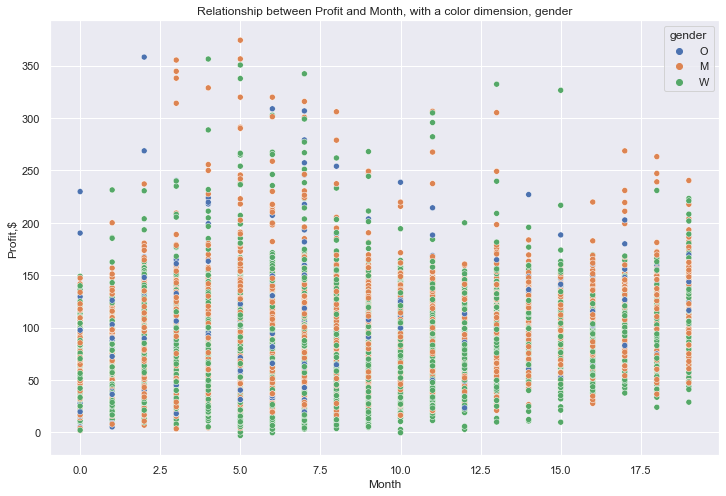

In [7]:
# relationship between profit and month, color being gender
# discount increases for women over time
plt.figure(figsize=(12,8))
sns.scatterplot(x="month", y="profit",hue="gender", data=df5)
plt.ylabel('Profit,$')
plt.xlabel('Month')
plt.title('Relationship between Profit and Month, with a color dimension, gender')
plt.show()

In [8]:
# average profit and discount per customer state and month
state_df = df6.groupby(['cust_state','month']).agg({'profit':['mean'],'discount':['mean']})
state_df.columns = ['profit_mean','discount_mean']
state_df = state_df.reset_index()
print(state_df)

    cust_state  month  profit_mean  discount_mean
0           AC      0    42.190000       0.000000
1           AC      1    42.866000       0.000000
2           AC      2    43.717143       0.000000
3           AC      3    44.222000       0.000000
4           AC      4    36.933750       0.000000
..         ...    ...          ...            ...
531         TO     15    36.892500      18.750000
532         TO     16    40.995000      25.000000
533         TO     17    51.265000      12.500000
534         TO     18    46.205000      12.500000
535         TO     19    51.223333       8.333333

[536 rows x 4 columns]


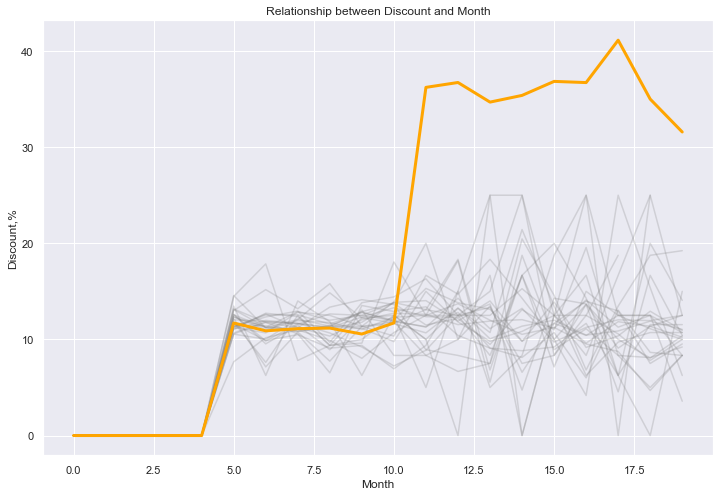

In [9]:
# There is one state in which discounts increase a lot. What state is it?
plt.figure(figsize=(12,8))
state = 'MG'
for st in state_df.cust_state.unique():
    if st != state:
        sns.lineplot(x='month', y='discount_mean', data=state_df[state_df['cust_state'] == st], alpha=0.25, color='grey')
sns.lineplot(x='month', y='discount_mean', data=state_df[state_df['cust_state'] == state], alpha=1, color='orange', linewidth=3)
plt.ylabel('Discount,%')
plt.xlabel('Month')
plt.title('Relationship between Discount and Month')
plt.show()

In [10]:
# discounts are given to women, but not to all of them

df7 =df6.copy()

post_intervention = []
for row in df7.loc[:,('month')]:
    if row > 5:
        post_intervention.append('True')
    else:
        post_intervention.append('False')
df7['post_intervention'] = post_intervention

# still unsure about the instructions
treated = []
for row in df7.loc[:,('gender')]:
    if row == 'W':
        treated.append('True')
    elif row == 'M':
        treated.append('False - Men')
    else:
        treated.append('False - Other')
df7['treated'] = treated
print(df7)

         sales  discount  age gender cust_state  tenure  profit  month  \
0      1153.28         0   25      O         MA      19   57.66      7   
1      1978.13         0   26      M         MG      16   98.91      6   
2      1095.70         0   26      W         RJ      20   54.78      2   
3      2404.90        25   30      W         BA      18   95.24      6   
4      1704.80         0   38      M         PB      15   85.24      4   
...        ...       ...  ...    ...        ...     ...     ...    ...   
49994  3186.48        25   29      W         DF      15  134.32     15   
49995  2083.30         0   29      W         SP      15  104.17      0   
49996  1110.16        25   29      W         MT      16   30.51     13   
49997  2495.62        25   31      M         MG      18   99.78     11   
49998  1951.28         0   30      O         SP      24   97.56      0   

      post_intervention        treated  
0                  True  False - Other  
1                  True    Fa

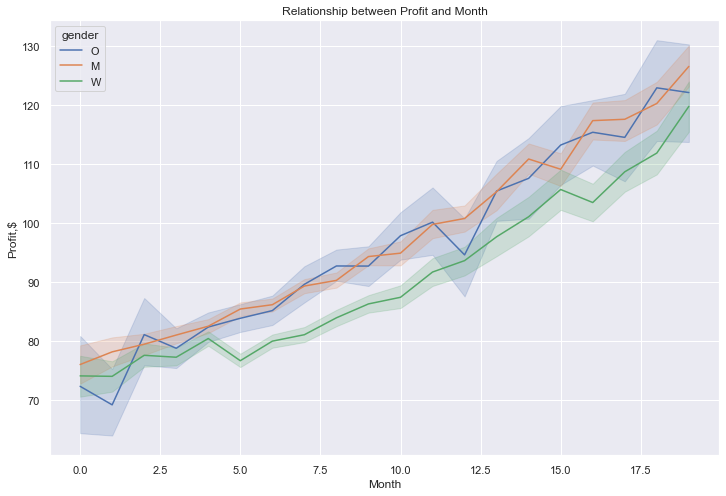

In [11]:
# plot profits by month and gender
plt.figure(figsize=(12,8))
sns.lineplot(x='month', y='profit',hue='gender', data=df6)
plt.ylabel('Profit,$')
plt.xlabel('Month')
plt.title('Relationship between Profit and Month')
plt.show()
# Do treated and control groups have the same profit levels before the intervention? they seem to follow then same trend.
# For the treated group, is average profit growing before the intervention? practically there is no growth in profit before the intervention.
# Do treated and control groups seem to have parallel profit trends before the intervention period? No,they seem to not have different profit trends.

In [12]:
# compute the average profit for the treated group (woman) before the intervention -> post_intervention = false and treated = true
# compute the average profit for the treated group (woman) after the intervention -> post_intervention = true and treated = true
# compute the average profit for the control group (men) after the intervention -> post_intervention = true and treated = false-men

result_interventions = df7.groupby(['post_intervention', 'treated']).agg({'profit':'mean'}).reset_index()
#result_interventions = result_interventions[result_interventions['treated'].str.contains('False - Men')]
#result_interventions = result_interventions[result_interventions['post_intervention'].str.contains('False')]
result_interventions
# average profit for the treated group (women) before the intervention = 77.686601
# average profit for the treated group (women) after the intervention = 87.322208
# for the treated grouo, the difference in profits before and after the discount increase is of 9.635607
# under which conditions is this the causal effect of discounts on profits? there is a considerable increase in profit after discounts have been applied
 
# average profit for the control group (men) after the intervention = 94.822954
# the difference in profits after the intervention between treated and control group is of 7.136353
# under which conditions is this the causal effect of discounts on profits? this is telling us that discounts are not being leveraged
# this could be violated if women's profit were in another level than men's

post_intervention        treated     profit
0             False    False - Men  82.363024
1             False  False - Other  80.849952
2             False           True  77.686601
3              True    False - Men  94.822954
4              True  False - Other  94.535540
5              True           True  87.322208

In [13]:
treatment_before = result_interventions[(result_interventions['post_intervention'].str.contains('False'))\
                                        & (result_interventions['treated'].str.contains('True'))].profit.item()
treatment_after = result_interventions[(result_interventions['post_intervention'].str.contains('True'))\
                                        & (result_interventions['treated'].str.contains('True'))].profit.item()
control_before = result_interventions[(result_interventions['post_intervention'].str.contains('False'))\
                                        & (result_interventions['treated'].str.contains('Men'))].profit.item()
control_after = result_interventions[(result_interventions['post_intervention'].str.contains('True'))\
                                        & (result_interventions['treated'].str.contains('Men'))].profit.item()

In [14]:
dd = (control_before - control_after) - (treatment_before - treatment_after) 
dd

-2.8243230572733182

In [15]:
result_interventions

post_intervention        treated     profit
0             False    False - Men  82.363024
1             False  False - Other  80.849952
2             False           True  77.686601
3              True    False - Men  94.822954
4              True  False - Other  94.535540
5              True           True  87.322208

In [16]:
result_interventions = result_interventions[~(result_interventions['treated']=='False - Other')]

In [17]:
result_interventions.post_intervention = result_interventions.post_intervention.apply(lambda x: {'False':0,'True':1}[x])
result_interventions.treated = result_interventions.treated.apply(lambda x: {'False - Men':0,'True':1}[x])                                                                                                                                                                                                
result_interventions

post_intervention  treated     profit
0                  0        0  82.363024
2                  0        1  77.686601
3                  1        0  94.822954
5                  1        1  87.322208

In [18]:
mod = smf.ols(formula='profit ~ post_intervention*treated', data=result_interventions)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 16 Jul 2022   Prob (F-statistic):                nan
Time:                        16:40:18   Log-Likelihood:                 115.64
No. Observations:                   4   AIC:                            -223.3
Df Residuals:                       0   BIC:                            -225.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

c:\users\oscar\appdata\local\programs\python\python39\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
c:\users\oscar\appdata\local\programs\python\python39\lib\site-packages\statsmodels\regression\linear_model.py:1749: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\users\oscar\appdata\local\programs\python\python39\lib\site-packages\statsmodels\regression\linear_model.py:1749: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\users\oscar\appdata\local\programs\python\python39\lib\site-packages\statsmodels\regression\linear_model.py:1671: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


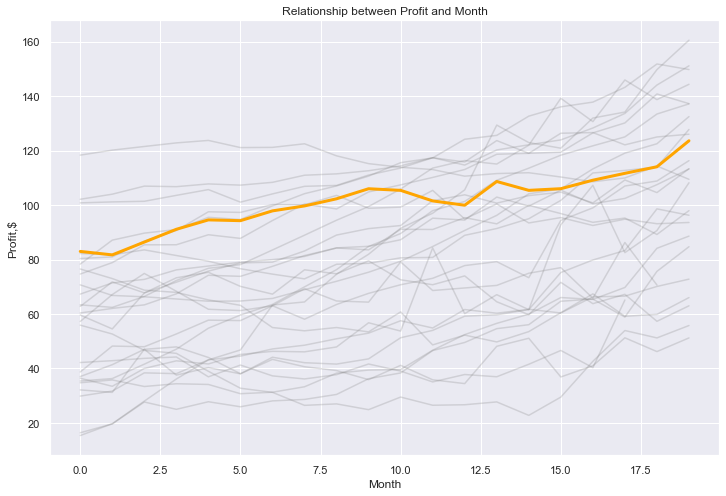

In [19]:
# There is one state in which discounts increase a lot. What state is it?
state = 'MG'
plt.figure(figsize=(12,8))
for st in state_df.cust_state.unique():
    if st != state:
        sns.lineplot(x='month', y='profit_mean', data=state_df[state_df['cust_state'] == st], alpha=0.25, color='grey')
sns.lineplot(x='month', y='profit_mean', data=state_df[state_df['cust_state'] == state], alpha=1, color='orange', linewidth=3)
plt.ylabel('Profit,$')
plt.xlabel('Month')
plt.title('Relationship between Profit and Month')
plt.show()

In [20]:
# filter only the preintervention period (month < 11)
output = pd.pivot_table(data = df6, index = ['month'], columns = ['cust_state'], values = 'profit', aggfunc = 'mean')
output2 = output.dropna(how="any",axis=0)
output2.query('month < 11')

cust_state         AC         AL         AM         AP         BA          CE  \
month                                                                           
0           42.190000  55.910667  62.797273  59.610000  67.308667   78.322400   
1           42.866000  52.664500  71.811034  54.530000  71.429101   87.127708   
2           43.717143  46.642424  67.769556  67.715000  72.711594   89.695510   
3           44.222000  45.559074  71.686447  73.302500  76.211619   91.024790   
4           36.933750  38.970641  75.757404  75.322500  77.616177   95.502242   
5           41.258846  32.748713  78.758033  70.144000  79.028911   94.698382   
6           37.285417  31.235789  79.049196  67.299286  79.974758   99.699846   
7           36.162400  26.465811  83.137570  76.230278  81.133835  104.180200   
8           37.730526  27.000357  88.987639  74.764737  84.273043  107.034167   
9           41.646667  24.886531  91.357313  79.505455  84.855928  110.628065   
10          39.040000  29.510000  92.480000  72.572222  87.263095  115.565405   

cust_state         DF          ES          GO         MA  ...          PR  \
month                                                     ...               
0           15.385385   80.367273  118.333636  82.215172  ...   74.673750   
1           19.713333   80.957917  120.162857  81.756923  ...   78.873922   
2           28.019333   86.792195  121.509194  83.543099  ...   85.412593   
3           36.144000   90.671013  122.825203  81.479844  ...   85.426141   
4           43.171351   97.531905  123.732772  79.380843  ...   89.103043   
5           46.798810   97.306273  121.107553  76.624238  ...   87.763243   
6           63.307662  100.176391  121.182000  74.643674  ...   94.324984   
7           64.428554  100.092667  122.501132  72.908967  ...  100.376115   
8           74.612537  103.552933  118.070268  78.268600  ...   98.580149   
9           81.937368   98.818947  115.209651  78.611149  ...  104.812384   
10          91.497692   99.251579  113.883692  80.625000  ...  107.418701   

cust_state         RJ          RN         RO         RR         RS         SC  \
month                                                                           
0           70.698936   63.367778  38.720000  57.260000  35.405313  29.866154   
1           66.816711   62.437647  48.229231  67.148000  36.301379  31.706585   
2           66.322000   66.444359  47.990556  74.894286  41.587909  38.391833   
3           65.522671   72.311111  52.673667  68.352500  47.098359  38.106190   
4           64.696406   76.793151  57.746486  61.747273  54.792963  43.167216   
5           64.771302   78.130000  57.587547  61.268947  59.628916  44.541505   
6           65.720605   83.514231  63.037826  63.027143  63.527701  47.170496   
7           68.932182   88.935942  58.092667  69.290000  69.967570  48.547368   
8           72.015891   94.438630  63.502083  64.785000  76.292887  50.908649   
9           75.347571   99.460217  67.586154  64.364000  84.808452  52.983125   
10          79.374737  105.882121  70.744444  79.125000  89.549770  57.525970   

cust_state         SE          SP         TO  
month                                         
0           16.405000  102.130641  37.040000  
1           19.660000  103.996038  41.401250  
2           27.690455  106.953490  47.035455  
3           25.011087  106.753658  47.928125  
4           27.794000  107.764774  44.043103  
5           25.945541  107.316853  38.075714  
6           28.108254  108.348157  43.344884  
7           28.641692  110.955201  40.643200  
8           30.470952  111.459437  39.246818  
9           36.255000  112.603582  35.911250  
10          38.362105  114.388698  41.153333  

[11 rows x 27 columns]

In [21]:
output2.isnull().sum().sum()

0

In [22]:
y = output2['MG']
X = output2[output.columns.difference(['MG'])]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=42)

enet_model = ElasticNet(alpha=50, fit_intercept=False, max_iter=10000).fit(X_train, y_train)

enet_model.fit(X_train, y_train)

ElasticNet(alpha=50, fit_intercept=False, max_iter=10000)

In [23]:
y_pred = enet_model.predict(X_test)
y_pred

array([ 83.33923784,  86.13540606,  94.1763176 , 109.17868894,
       105.70969695])

In [24]:
weights = enet_model.coef_
weights

array([0.        , 0.        , 0.05135955, 0.        , 0.        ,
       0.1093259 , 0.0416901 , 0.25678849, 0.17795128, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.0931102 ,
       0.        , 0.11214855, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.11215256,
       0.        ])

In [25]:
output_no_MG = output2.copy()
del output_no_MG["MG"]
output_no_MG

cust_state         AC         AL          AM         AP          BA  \
month                                                                 
0           42.190000  55.910667   62.797273  59.610000   67.308667   
1           42.866000  52.664500   71.811034  54.530000   71.429101   
2           43.717143  46.642424   67.769556  67.715000   72.711594   
3           44.222000  45.559074   71.686447  73.302500   76.211619   
4           36.933750  38.970641   75.757404  75.322500   77.616177   
5           41.258846  32.748713   78.758033  70.144000   79.028911   
6           37.285417  31.235789   79.049196  67.299286   79.974758   
7           36.162400  26.465811   83.137570  76.230278   81.133835   
8           37.730526  27.000357   88.987639  74.764737   84.273043   
9           41.646667  24.886531   91.357313  79.505455   84.855928   
10          39.040000  29.510000   92.480000  72.572222   87.263095   
11          35.070000  26.506190  101.592778  70.754000   95.190968   
13          36.965000  27.727273  100.713846  64.496667  102.933774   
14          41.550000  22.791667  103.470526  59.745000   99.617838   
15          46.616667  29.494000  104.736667  71.630000  105.473095   
16          40.305000  42.627143  100.794167  63.800000  100.463810   
17          65.142500  53.937500  109.211250  67.230000  102.441714   

cust_state          CE          DF          ES          GO          MA  ...  \
month                                                                   ...   
0            78.322400   15.385385   80.367273  118.333636   82.215172  ...   
1            87.127708   19.713333   80.957917  120.162857   81.756923  ...   
2            89.695510   28.019333   86.792195  121.509194   83.543099  ...   
3            91.024790   36.144000   90.671013  122.825203   81.479844  ...   
4            95.502242   43.171351   97.531905  123.732772   79.380843  ...   
5            94.698382   46.798810   97.306273  121.107553   76.624238  ...   
6            99.699846   63.307662  100.176391  121.182000   74.643674  ...   
7           104.180200   64.428554  100.092667  122.501132   72.908967  ...   
8           107.034167   74.612537  103.552933  118.070268   78.268600  ...   
9           110.628065   81.937368   98.818947  115.209651   78.611149  ...   
10          115.565405   91.497692   99.251579  113.883692   80.625000  ...   
11          117.311930   96.999130  105.385484  113.030600   80.777381  ...   
13          125.586400  129.364444  100.406667  111.564400   91.392000  ...   
14          132.646786  122.941111   93.432000  111.872632   94.983333  ...   
15          136.068667  120.885000   95.407778  110.303500  101.729444  ...   
16          137.796176  131.948889   92.513636  108.549524  111.783846  ...   
17          143.227407  134.151667   94.819091  109.953500  112.728421  ...   

cust_state          PR          RJ          RN          RO         RR  \
month                                                                   
0            74.673750   70.698936   63.367778   38.720000  57.260000   
1            78.873922   66.816711   62.437647   48.229231  67.148000   
2            85.412593   66.322000   66.444359   47.990556  74.894286   
3            85.426141   65.522671   72.311111   52.673667  68.352500   
4            89.103043   64.696406   76.793151   57.746486  61.747273   
5            87.763243   64.771302   78.130000   57.587547  61.268947   
6            94.324984   65.720605   83.514231   63.037826  63.027143   
7           100.376115   68.932182   88.935942   58.092667  69.290000   
8            98.580149   72.015891   94.438630   63.502083  64.785000   
9           104.812384   75.347571   99.460217   67.586154  64.364000   
10          107.418701   79.374737  105.882121   70.744444  79.125000   
11          110.141429   84.775310  113.579286   73.107500  68.628000   
13          118.652250   96.219524  115.061000   79.222000  70.500000   
14          119.005294  104.148571  121.970909   73.3

In [26]:
synthetic_control = output_no_MG * weights

In [27]:
# creating dataframe with only MG
output_only_MG = output2.copy()
output_only_MG = output_only_MG[['MG']]
output_only_MG

cust_state          MG
month                 
0            82.985962
1            81.710388
2            86.413143
3            91.107768
4            94.558234
5            94.272010
6            97.865540
7            99.681568
8           102.303365
9           105.995343
10          105.400743
11          101.525906
13          108.656875
14          105.399692
15          106.012456
16          109.126719
17          111.653871

<AxesSubplot:xlabel='month'>

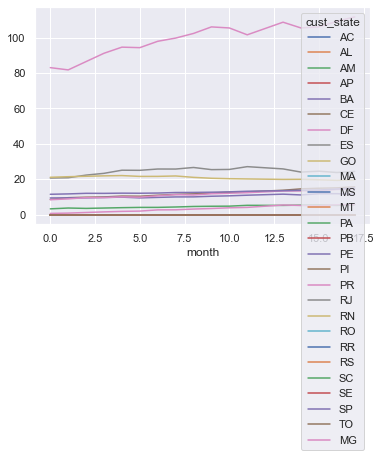

In [28]:
# plot the synthetic control and the state of MG across months
ax = synthetic_control.plot()
output_only_MG.plot(ax=ax)

# i also need to plot the difference between the state of MG and the synthetic control over time